In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import os
for dirname, _, filenames in os.walk('tmlcc-feated'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tmlcc-feated/test.csv
tmlcc-feated/train.csv


In [2]:
# Read the data
train_data_full = pd.read_csv('tmlcc-feated/train.csv', index_col='MOFname')
#test_data_full = pd.read_csv('tmlcc-2021/train.csv', index_col='MOFname')

train_data_full.info()
#train_data_full.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 68613 entries, mof_unit_1 to mof_unit_68613
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   volume [A^3]                                   68613 non-null  float64
 1   weight [u]                                     68613 non-null  float64
 2   surface_area [m^2/g]                           68613 non-null  float64
 3   void_fraction                                  68613 non-null  float64
 4   void_volume [cm^3/g]                           68613 non-null  float64
 5   functional_groups                              68290 non-null  object 
 6   metal_linker                                   68613 non-null  int64  
 7   organic_linker1                                68613 non-null  int64  
 8   organic_linker2                                68613 non-null  int64  
 9   topology                             

In [3]:
train_data_full.columns

Index(['volume [A^3]', 'weight [u]', 'surface_area [m^2/g]', 'void_fraction',
       'void_volume [cm^3/g]', 'functional_groups', 'metal_linker',
       'organic_linker1', 'organic_linker2', 'topology', 'CO2/N2_selectivity',
       'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
       'CO2_working_capacity [mL/g]', 'cif_H', 'cif_B', 'cif_C', 'cif_N',
       'cif_O', 'cif_F', 'cif_P', 'cif_S', 'cif_Cl', 'cif_V', 'cif_Cr',
       'cif_Ni', 'cif_Cu', 'cif_Zn', 'cif_Br', 'cif_I', 'cif_Ba'],
      dtype='object')

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


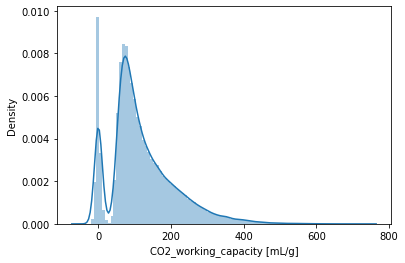

In [4]:
ax = sns.distplot(train_data_full['CO2_working_capacity [mL/g]'],bins=100)

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 50.0)

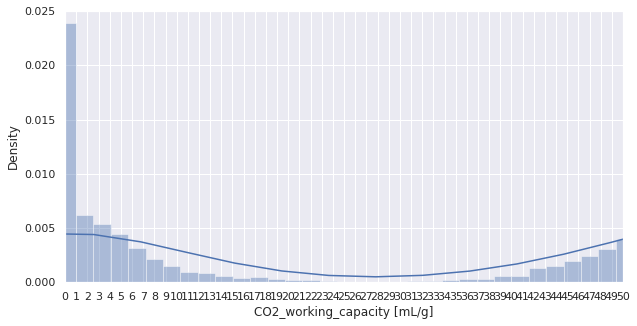

In [5]:
min_t = int(train_data_full['CO2_working_capacity [mL/g]'].min())
max_t = int(train_data_full['CO2_working_capacity [mL/g]'].max())
interval = int((min_t-max_t)/2)
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.distplot(train_data_full['CO2_working_capacity [mL/g]'],bins=500)
ax.set_xticks(range(min_t,max_t,1))
ax.set_xlim(0,50)




Look like it seperate at value = 28 

In [6]:
#found invalid data in surface_area <0 and void_fraction <0 
#mark them with NaN value
data_full = train_data_full.copy()
data_full.loc[data_full['surface_area [m^2/g]'] <= 0,'surface_area [m^2/g]'] = np.nan
data_full.loc[data_full['surface_area [m^2/g]'] == 0,'surface_area [m^2/g]'] = -1
data_full.loc[data_full['void_fraction'] <= 0,'void_fraction'] = np.nan
data_full.loc[data_full['void_volume [cm^3/g]'] <= 0,'void_volume [cm^3/g]'] = np.nan
data_full.loc[data_full['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'] == np.inf,
                    'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'] = np.nan


#train_data_full.drop(["weight [u]","volume [A^3]"], axis=1, inplace=True)

In [7]:
data_full.insert(
    loc=3,
    column="density [g/cm^3]",
    value=(data_full["weight [u]"] / data_full["volume [A^3]"]) * 1.66054,
)
#data_full = data_full.drop(columns=["weight [u]","volume [A^3]"],inplace=False)

In [8]:
missing_val_count_by_column = (data_full.isnull().sum())
print("missing data count by column")
print(missing_val_count_by_column[missing_val_count_by_column > 0])


missing data count by column
surface_area [m^2/g]                             14539
void_fraction                                     2930
void_volume [cm^3/g]                              3130
functional_groups                                  323
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]     2089
dtype: int64


In [9]:
imputer_df = data_full.dropna(axis = 0,inplace=False)

In [10]:
numeric_cols = ['volume [A^3]',
                'weight [u]',
                'surface_area [m^2/g]',
                'void_fraction',
                'density [g/cm^3]',
                'void_volume [cm^3/g]',
                'CO2/N2_selectivity',
                'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']
cif_cols = [#'cif_H', 'cif_B', 
            'cif_C', #'cif_N',
            #'cif_O', 'cif_F', 'cif_P', 'cif_S', 'cif_Cl', 'cif_Br' ,
            'cif_V', 'cif_Cr',
            'cif_Ni', 'cif_Cu', 'cif_Zn', 'cif_I', 'cif_Ba']
ordinal_cols = ['organic_linker1', 'organic_linker2']
one_hot_cols = ['topology','metal_linker']
encode_cols = ['functional_groups']
feature_cols = [*numeric_cols,*ordinal_cols,*one_hot_cols,*encode_cols,*cif_cols]
target_cols = ['CO2_working_capacity [mL/g]']

In [11]:
imputer_df.head()

volume [A^3]   weight [u]  surface_area [m^2/g]  density [g/cm^3]  \
MOFname                                                                         
mof_unit_2   2769.503842  2211.697211                603.61          1.326090   
mof_unit_3   1089.818728   773.687960                788.50          1.178856   
mof_unit_4   2205.198301  1304.638720               1441.53          0.982408   
mof_unit_6   3954.659761  1543.027680               2430.55          0.647909   
mof_unit_7   3565.914939  1954.749656               1530.02          0.910268   

            void_fraction  void_volume [cm^3/g] functional_groups  \
MOFname                                                             
mof_unit_2        0.13794                0.1040             F-OMe   
mof_unit_3        0.14874                0.1262          OMe-COOH   
mof_unit_4        0.21814                0.2220            H-SO3H   
mof_unit_6        0.37094                0.5725            Pr-NO2   
mof_unit_7        0.33337                0.3662               NH2   

            metal_linker  organic_linker1  organic_linker2  ... cif_S  cif_Cl  \
MOFname                                                     ...                 
mof_unit_2            10               44               57  ...     0       0   
mof_unit_3             2               22               24  ...     0       0   
mof_unit_4             9               17               24  ...     1       0   
mof_unit_6             9                7               23  ...     0       0   
mof_unit_7            10               53               55  ...     0       0   

            cif_V  cif_Cr  cif_Ni  cif_Cu  cif_Zn  cif_Br  cif_I  cif_Ba  
MOFname                                                                   
mof_unit_2      0       0       0       0       0       0      0       2  
mof_unit_3      0       0       0       2       0       0      0       0  
mof_unit_4      4       0       0       0       0       0      0       0  
mof_unit_6      4       0       0       0       0       0      0       0  
mof_unit_7      0       0       0       0       0       0      0       2  

[5 rows x 31 columns]

In [60]:
def fcn_splitter(fcn_group):
    
    list_fcn = [re.sub(r"[^a-zA-Z0-9]", " ", str(word)) for word in fcn_group]
    return [a.split() for a in list_fcn]

def dict_generator(list_df):
    atom_dict = {}
    for row_text in list_df:
        for word in row_text:
            if word == []:
                atom_dict[no_atom] +=1
            else:
                if str(word) in atom_dict:
                    atom_dict[word] +=1
                else:
                    atom_dict[word] =1
    list_dict = sorted(atom_dict, key=atom_dict.get,reverse=True)
    return list_dict,atom_dict
    
def map_atom(word,func_list):
    atom_dict = {k: v for k, v in zip(func_list, [0]*len(func_list))}
    for fcn_one in word:
        if fcn_one in func_list:
            atom_dict[fcn_one] +=1
            
    return atom_dict
    
def function2Dict(MOF_G,func_list):
    index_t = MOF_G.index
    list_mof = MOF_G.tolist()
    list_out = []
    
    for word in list_mof:
        splited_fcn = fcn_splitter([word])
        list_out.append(map_atom(*splited_fcn,func_list))

    n = pd.DataFrame.from_dict(list_out)
    n.index = index_t      
    return n

def embed_atom_transform(df,func_list):
    data = df['functional_groups']
    a = function2Dict(data,func_list)
    data_F = df.drop(['functional_groups'], axis=1, inplace=False)
    return pd.concat([data_F,a],axis=1) 


In [13]:
from sklearn.preprocessing import OneHotEncoder

def one_code_data_fit(dataset,categorical_cols):
    '''
    fit and transform data with One-Hot Encoder
    REQUIRE :   dataset (pandas.dataFrame) ,
                categorical_cols (list) ,
    RETURN :    OH_dataset (encoded dataset), OH_encoder (one-hot object)
    '''
    # Apply one-hot encoder to each column with categorical data
    # Encoder object 
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    # fit the encoder
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[categorical_cols]))
    
    # One-hot encoding removed index; put it back
    OH_cols.index = dataset.index
    
    # Remove categorical columns (will replace with one-hot encoding)
    num_X_reduce = dataset.drop(categorical_cols, axis=1)
    
    # Add one-hot encoded columns to numerical features
    OH_dataset = pd.concat([num_X_reduce, OH_cols], axis=1)
    return OH_dataset , OH_encoder

def one_code_data_transform(dataset,categorical_cols,OH_encoder):
    '''
    Transform data with One-Hot Encoder
    REQUIRE :   dataset (pandas.dataFrame) ,
                categorical_cols (list) ,
                OH_encoder (one-hot-encoder object)
    RETURN : Encoded dataset
    '''
    # fit the encoder
    OH_cols = pd.DataFrame(OH_encoder.transform(dataset[categorical_cols]))
    # One-hot encoding removed index; put it back
    OH_cols.index = dataset.index
    
    # Remove categorical columns (will replace with one-hot encoding)
    num_X_reduce = dataset.drop(categorical_cols, axis=1)
    
    # Add one-hot encoded columns to numerical features
    OH_dataset = pd.concat([num_X_reduce, OH_cols], axis=1)
    return OH_dataset 

In [14]:
def replace_num_OH(dataset,col,list_num,str_col):
    dict = {}
    for num in list_num:
        dict[num] = str_col+str(num)
    #print(dict)
    dataset[col].replace(dict).astype('object')
    return dataset
list_num =[1,2,3,4,9,10,12]
test_df = replace_num_OH(imputer_df,'metal_linker',list_num,'metal_')

In [15]:
#test_df.head()

In [16]:
OH_data , OH_encoder = one_code_data_fit(test_df,one_hot_cols)

In [17]:
data = OH_data['functional_groups']
text1 = fcn_splitter(data)
func_list,atom_list = dict_generator(text1)

a = function2Dict(data,func_list)

data_F = OH_data.drop(['functional_groups'], axis=1, inplace=False)

train_data_atom = pd.concat([data_F,a],axis=1) 

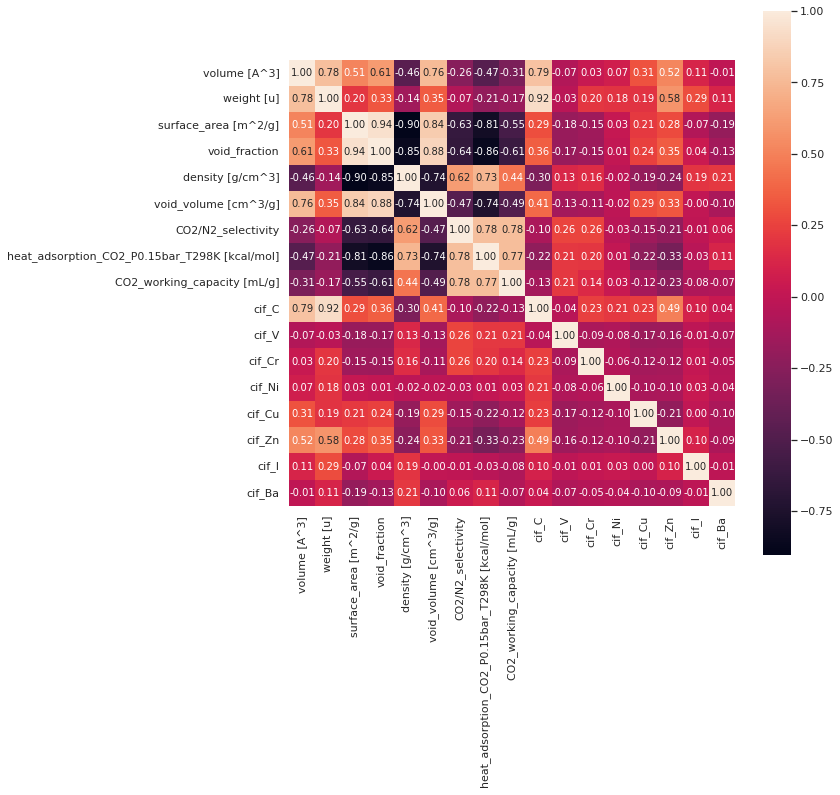

In [18]:
#'surface_area [m^2/g]' correlation matrix
cols = [*numeric_cols,*target_cols,*cif_cols]
corrmat = train_data_atom[cols].corr()
sns.set(rc={'figure.figsize':(10,10)})
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})


/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

 mu = 110.73 and sigma = 82.87



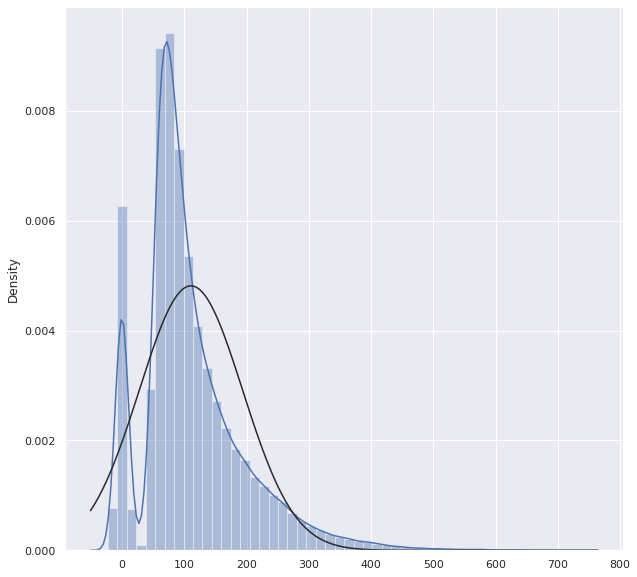

In [19]:
from scipy.stats import norm, skew 
(mu, sigma) = norm.fit(train_data_atom[target_cols])
sns.distplot(train_data_atom[target_cols] , fit=norm)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

In [20]:
train_data_atom

volume [A^3]   weight [u]  surface_area [m^2/g]  \
MOFname                                                           
mof_unit_2       2769.503842  2211.697211                603.61   
mof_unit_3       1089.818728   773.687960                788.50   
mof_unit_4       2205.198301  1304.638720               1441.53   
mof_unit_6       3954.659761  1543.027680               2430.55   
mof_unit_7       3565.914939  1954.749656               1530.02   
...                      ...          ...                   ...   
mof_unit_66520   1426.479810  1272.451540               1343.62   
mof_unit_66521  23943.701366  5497.752320               4182.24   
mof_unit_66522  14389.971556  4396.164320               4149.64   
mof_unit_66523  16997.806645  3932.703680               4326.62   
mof_unit_66524   7391.212513  2142.468600               3835.28   

                density [g/cm^3]  void_fraction  void_volume [cm^3/g]  \
MOFname                                                                 
mof_unit_2              1.326090        0.13794                0.1040   
mof_unit_3              1.178856        0.14874                0.1262   
mof_unit_4              0.982408        0.21814                0.2220   
mof_unit_6              0.647909        0.37094                0.5725   
mof_unit_7              0.910268        0.33337                0.3662   
...                          ...            ...                   ...   
mof_unit_66520          1.481238        0.30190                0.2038   
mof_unit_66521          0.381279        0.66340                1.7399   
mof_unit_66522          0.507298        0.57051                1.1246   
mof_unit_66523          0.384191        0.66963                1.7430   
mof_unit_66524          0.481336        0.52491                1.0905   

                organic_linker1  organic_linker2  CO2/N2_selectivity  \
MOFname                                                                
mof_unit_2                   44               57           33.616780   
mof_unit_3                   22               24           19.263726   
mof_unit_4                   17               24           25.701377   
mof_unit_6                    7               23           17.146541   
mof_unit_7                   53               55           18.363791   
...                         ...              ...                 ...   
mof_unit_66520               12               21            5.867674   
mof_unit_66521                9               27            4.060772   
mof_unit_66522                9               20            4.313411   
mof_unit_66523                2                5            3.447440   
mof_unit_66524               22               23            4.943257   

                heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]  ...  NHMe  OPr  \
MOFname                                                        ...              
mof_unit_2                                           7.147286  ...     0    0   
mof_unit_3                                           6.347967  ...     0    0   
mof_unit_4                                           6.190085  ...     0    0   
mof_unit_6                                           5.398304  ...     0    0   
mof_unit_7                                           6.303857  ...     0    0   
...                                                       ...  ...   ...  ...   
mof_unit_66520                                       4.485481  ...     0    0   
mof_unit_66521                                       3.605688  ...     0    0   
mof_unit_66522                                       3.361233  ...     0    1   
mof_unit_66523                                       2.781566  ...     0    0   
mof_unit_66524                                       3.804150  ...     0    0   

                CN  Et  OEt  Br  I  Pr  Ph  NO_ATOM  
MOFname                                              
mof_unit_2       0   0    0   0  0   0   0        0  
mof_unit_3       0   0    0   0  0   0   

In [21]:
THRESHOLD = 200 # in units of mL CO2/g
TARGET = target_cols  # ค่าที่เราต้องการทำนาย
TARGET_BINARY = 'target_binned'
train_data_atom[TARGET_BINARY] = train_data_atom[TARGET]>THRESHOLD
X_data = train_data_atom.drop(columns=target_cols,axis=1,inplace=False)
y = train_data_atom[target_cols]


In [22]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 4242424242
np.random.seed(RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y, train_size=0.8,
                                                      test_size=0.2, random_state=RANDOM_SEED,
                                                      stratify=train_data_atom[TARGET_BINARY])             
                            

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=-1,strategy="mean")
imputer_cols = ['surface_area [m^2/g]']
X_train_imp = X_train.copy()
X_valid_imp = X_valid.copy()
X_train_imp[imputer_cols] = imputer.fit_transform(X_train_imp[imputer_cols])
X_valid_imp[imputer_cols] = imputer.transform(X_valid[imputer_cols])

In [24]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(X_train_imp[numeric_cols]))
#print(z)

In [25]:
threshold = 3
out_index = X_train_imp[numeric_cols][(z < threshold).all(axis=1)].index
print("Keeping {} row".format(out_index))
X_train_imp = X_train_imp.loc[out_index]
y_train = y_train.loc[out_index]

Keeping Index(['mof_unit_4805', 'mof_unit_44346', 'mof_unit_8241', 'mof_unit_28531',
       'mof_unit_54038', 'mof_unit_43521', 'mof_unit_49912', 'mof_unit_15336',
       'mof_unit_54842', 'mof_unit_57433',
       ...
       'mof_unit_6332', 'mof_unit_23652', 'mof_unit_22313', 'mof_unit_56325',
       'mof_unit_55641', 'mof_unit_52084', 'mof_unit_2893', 'mof_unit_61223',
       'mof_unit_34396', 'mof_unit_15191'],
      dtype='object', name='MOFname', length=39859) row


<h1>Explore with Log</h> 

In [26]:
y_log = np.log(y_train+50)
y_valid_log = np.log(y_valid+50)
y_log2 =np.log(y_log)

<AxesSubplot:xlabel='heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]', ylabel='CO2_working_capacity [mL/g]'>

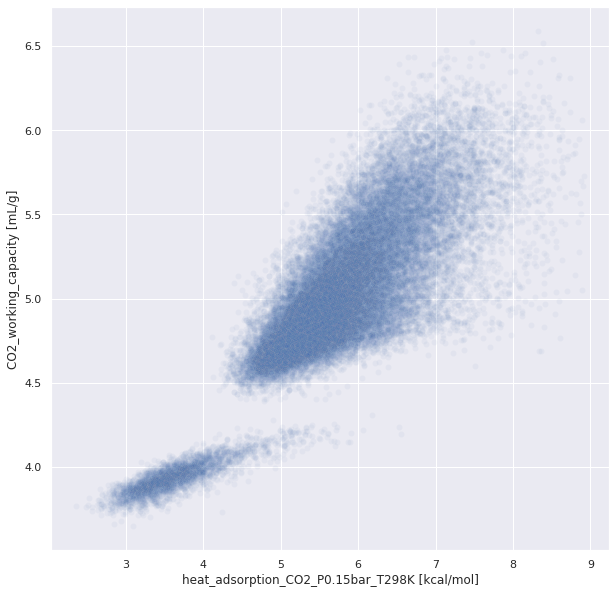

In [27]:
sns.scatterplot(
            data = pd.concat([X_train_imp,y_log],axis=1),
            y = 'CO2_working_capacity [mL/g]',
            x = "heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]",
            alpha=0.05
            )

In [28]:
eda = pd.concat([X_train_imp,y_train],axis=1)

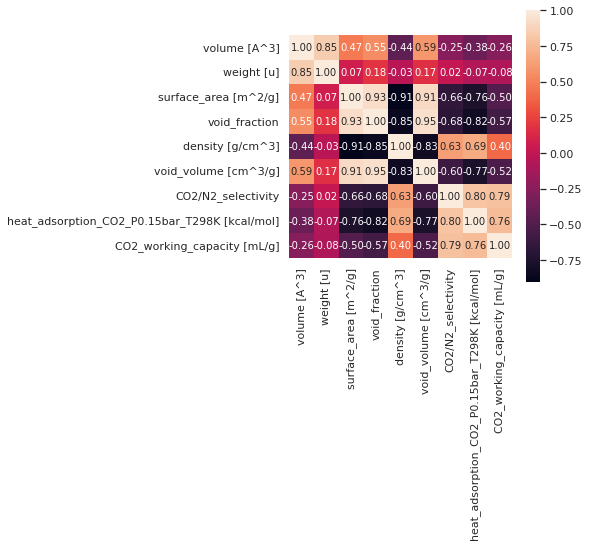

In [29]:
#'surface_area [m^2/g]' correlation matrix
cols = [*numeric_cols,*target_cols]
corrmat = eda[cols].corr()
sns.set(rc={'figure.figsize':(5,5)})
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

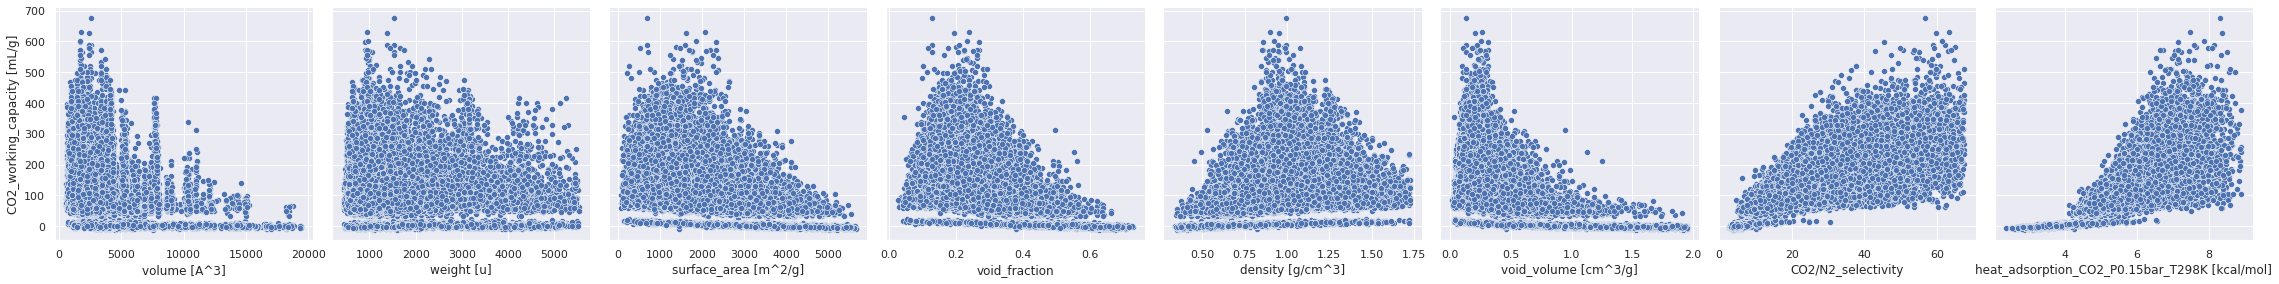

In [30]:
sns.pairplot(
            eda,
            x_vars= numeric_cols,
            y_vars= target_cols,
            height= 4,
            )

In [31]:
eda[numeric_cols] = np.log(eda[numeric_cols])

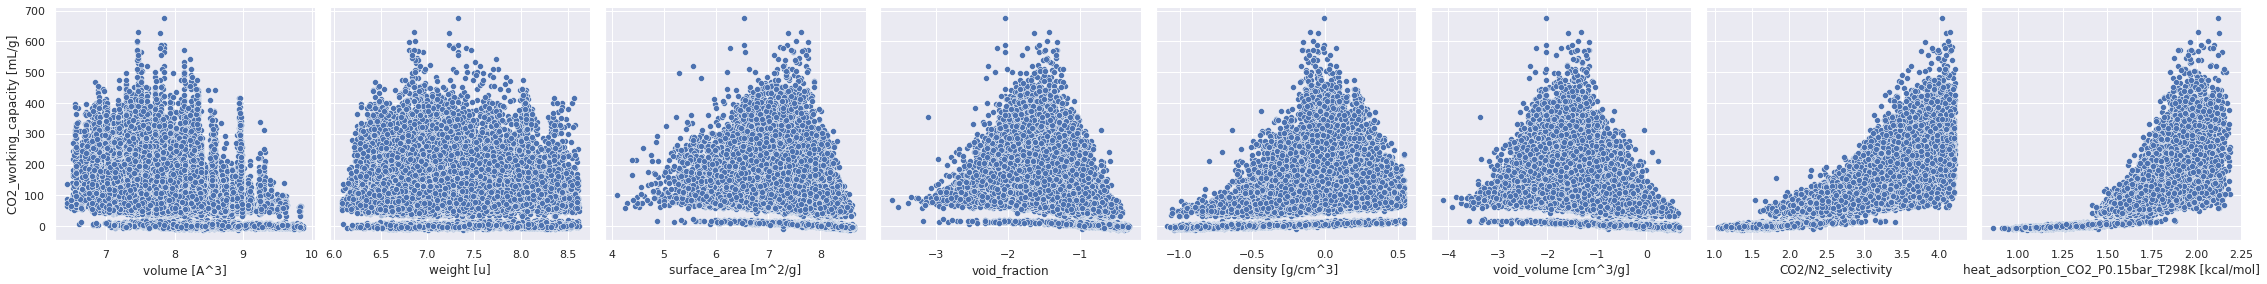

In [32]:
sns.pairplot(
            eda,
            x_vars= numeric_cols,
            y_vars= target_cols,
            height= 4,
            )

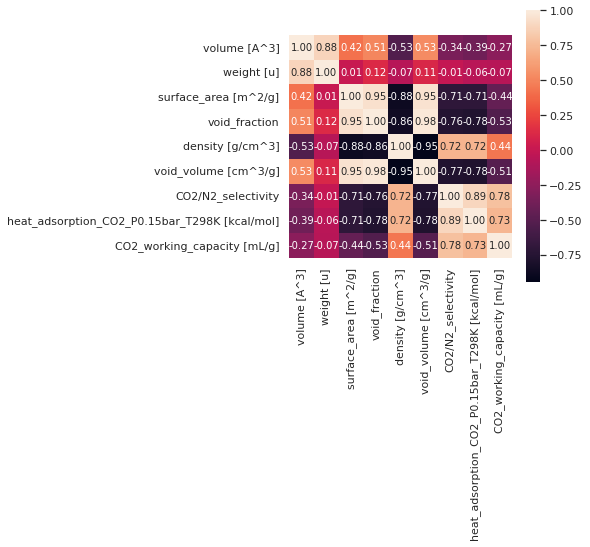

In [33]:
#'surface_area [m^2/g]' correlation matrix
cols = [*numeric_cols,*target_cols]
corrmat = eda[cols].corr()
sns.set(rc={'figure.figsize':(5,5)})
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [34]:
eda2 = pd.concat([X_train_imp,y_log],axis=1)

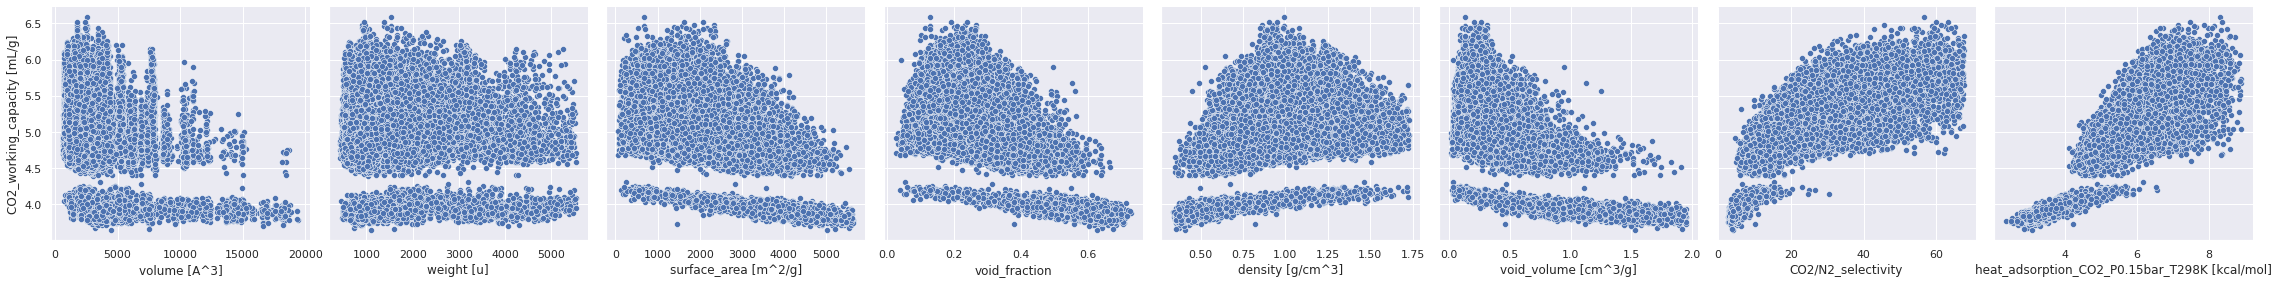

In [35]:
sns.pairplot(
            eda2,
            x_vars= numeric_cols,
            y_vars= target_cols,
            height= 4,
            )

In [36]:
eda2[numeric_cols] = np.log(eda2[numeric_cols])

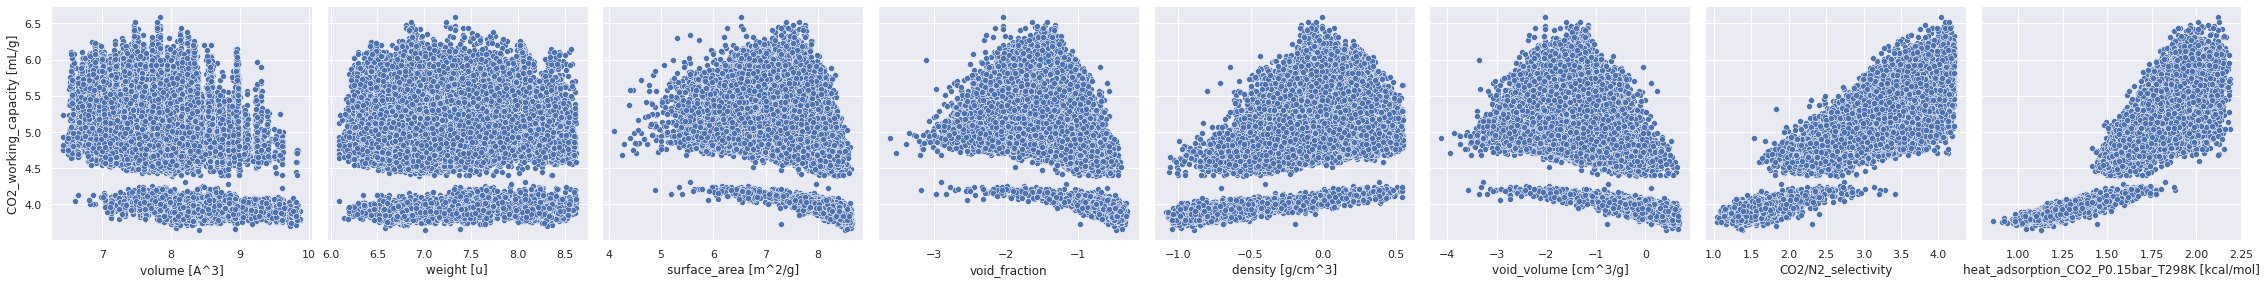

In [37]:
sns.pairplot(
            eda2,
            x_vars= numeric_cols,
            y_vars= target_cols,
            height= 4,
            )

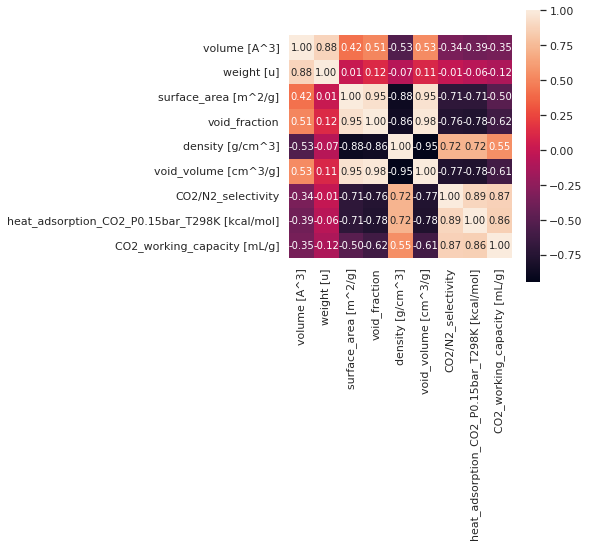

In [38]:
#'surface_area [m^2/g]' correlation matrix
cols = [*numeric_cols,*target_cols]
corrmat = eda2[cols].corr()
sns.set(rc={'figure.figsize':(5,5)})
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [39]:
numeric_cols

['volume [A^3]',
 'weight [u]',
 'surface_area [m^2/g]',
 'void_fraction',
 'density [g/cm^3]',
 'void_volume [cm^3/g]',
 'CO2/N2_selectivity',
 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']

In [40]:
log_cols = [
            'volume [A^3]',
            'weight [u]',
            "CO2/N2_selectivity",
            'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
            'density [g/cm^3]'
            ]
X_log = X_train_imp.copy()
for col in log_cols:
    X_log[col] = np.log(X_log[col])

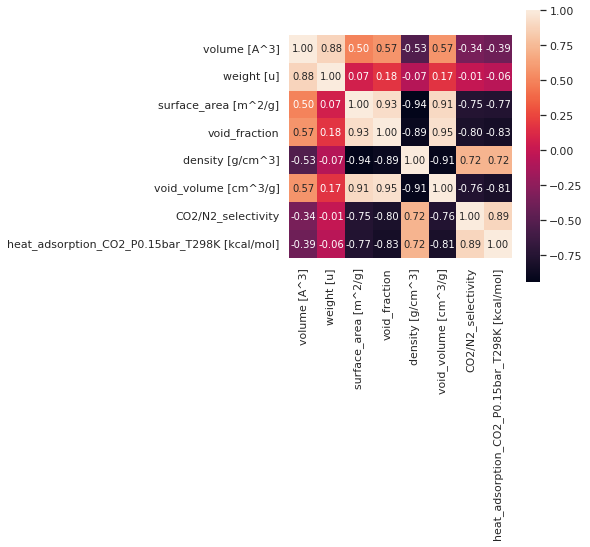

In [41]:
#'surface_area [m^2/g]' correlation matrix
cols = [*numeric_cols]
corrmat = X_log[cols].corr()
sns.set(rc={'figure.figsize':(5,5)})
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

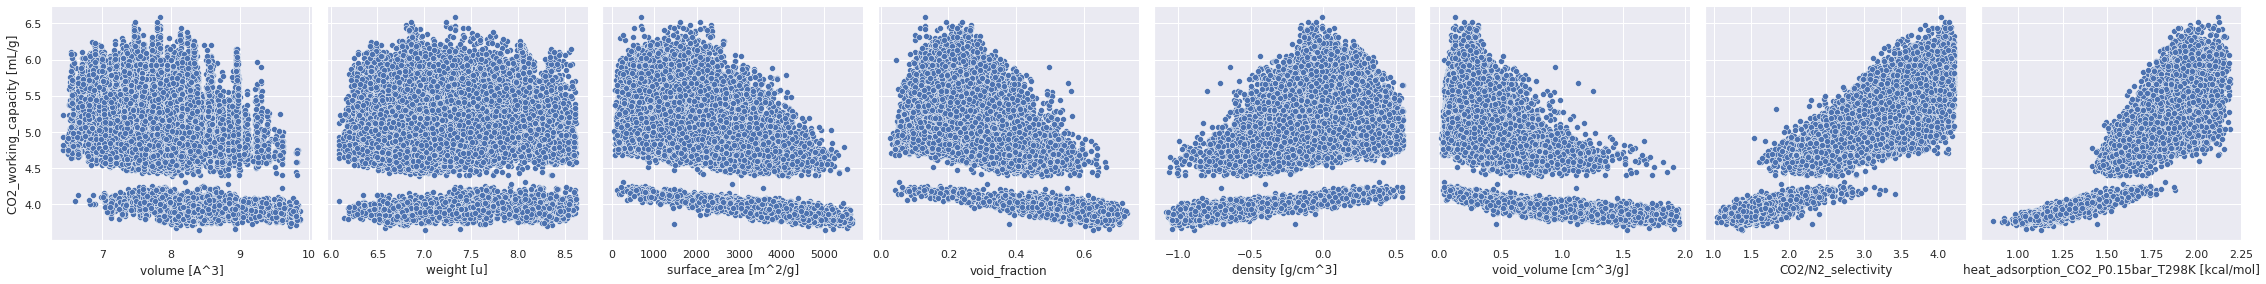

In [42]:
eda3 = pd.concat([X_log,y_log],axis=1)
sns.pairplot(
            eda3,
            x_vars= numeric_cols,
            y_vars= target_cols,
            height= 4,
            )

array([[<AxesSubplot:title={'center':'volume [A^3]'}>,
        <AxesSubplot:title={'center':'weight [u]'}>,
        <AxesSubplot:title={'center':'surface_area [m^2/g]'}>],
       [<AxesSubplot:title={'center':'void_fraction'}>,
        <AxesSubplot:title={'center':'density [g/cm^3]'}>,
        <AxesSubplot:title={'center':'void_volume [cm^3/g]'}>],
       [<AxesSubplot:title={'center':'CO2/N2_selectivity'}>,
        <AxesSubplot:title={'center':'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'}>,
        <AxesSubplot:>]], dtype=object)

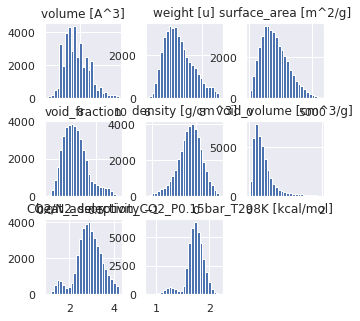

In [43]:
eda3[numeric_cols].hist(bins= 25)

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
cols =[*numeric_cols,*target_cols]
vari = eda3[cols]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(vari.values,i) for i in range(vari.shape[1])]
vif["feature"] = vari.columns
vif

VIF                                        feature
0  174443.661270                                   volume [A^3]
1  152453.674573                                     weight [u]
2      14.416075                           surface_area [m^2/g]
3      17.113678                                  void_fraction
4     252.846610                               density [g/cm^3]
5      13.294742                           void_volume [cm^3/g]
6       7.527334                             CO2/N2_selectivity
7       7.472754  heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]
8       6.008649                    CO2_working_capacity [mL/g]

So high Multicollinearity

In [45]:
from scipy.stats import multivariate_normal
pa = []
for col in numeric_cols:
    pval = {}
    (mu, sigma) = norm.fit(X_log[col])
    pval["mu"] = mu
    pval["cov"] = sigma**2
    pa.append(pval)
pval_df = pd.DataFrame(pa,index=numeric_cols)    

In [46]:
pval_df.mu

volume [A^3]                                        7.807269
weight [u]                                          7.159302
surface_area [m^2/g]                             2048.483892
void_fraction                                       0.296897
density [g/cm^3]                                   -0.140825
void_volume [cm^3/g]                                0.395638
CO2/N2_selectivity                                  2.867048
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]       1.719613
Name: mu, dtype: float64

Stratify data

In [48]:


X_log_valid = X_valid_imp.copy()
for col in log_cols:
    X_log_valid[col] = np.log(X_log_valid[col])
if TARGET_BINARY in X_log_valid.columns:
    X_log_valid = X_log_valid.drop(columns= TARGET_BINARY,inplace=False)
if TARGET_BINARY in X_log.columns:
    X_log = X_log.drop(columns= TARGET_BINARY,inplace=False)

In [49]:
y_valid = y_valid['CO2_working_capacity [mL/g]']
y_train = y_train['CO2_working_capacity [mL/g]']

In [50]:
train_cols = [
                'surface_area [m^2/g]',
                'void_fraction',
                'density [g/cm^3]',
                'CO2/N2_selectivity',
                'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
                #'metal_linker',
                #'organic_linker1',
                #'organic_linker2'
            ]


In [51]:
from xgboost import XGBRegressor
import xgboost as xgb

X_train_renamed = rename_cols(X_log)
X_valid_renamed = rename_cols(X_log_valid)
print(X_valid_renamed.columns)
xgb_model = XGBRegressor(n_estimators=500,learning_rate=0.1)
xgb_model.fit(X_train_renamed, y_log, 
             early_stopping_rounds=20, 
             eval_set=[(X_valid_renamed, y_valid_log)], 
             verbose=1)

xgb_predict = xgb_model.predict(X_valid_renamed)
valid_predict = np.exp(xgb_predict)-50
xgb_predict = xgb_model.predict(X_train_renamed)
train_predict = np.exp(xgb_predict)-50
LMAE = np.log(mean_absolute_error(valid_predict, y_valid))
print("xgb LMAE : ",LMAE)

Index(['volume__A_3_', 'weight__u_', 'surface_area__m_2_g_',
       'density__g_cm_3_', 'void_fraction', 'void_volume__cm_3_g_',
       'organic_linker1', 'organic_linker2', 'CO2_N2_selectivity',
       'heat_adsorption_CO2_P0_15bar_T298K__kcal_mol_', 'cif_H', 'cif_B',
       'cif_C', 'cif_N', 'cif_O', 'cif_F', 'cif_P', 'cif_S', 'cif_Cl', 'cif_V',
       'cif_Cr', 'cif_Ni', 'cif_Cu', 'cif_Zn', 'cif_Br', 'cif_I', 'cif_Ba',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', 'H', 'OH', 'NO2', 'OMe', 'HCO', 'F', 'Cl',
       'NH2', 'Me', 'COOH', 'SO3H', 'NHMe', 'OPr', 'CN', 'Et', 'OEt', 'Br',
       'I', 'Pr', 'Ph', 'NO_ATOM'],
      dtype='object')
[0]	validation_0-rmse:4.02595
[1]	validation_0-rmse:3.62416
[2]	validation_0-rmse:3.26278
[3]	validation_0-rmse:2.93774
[4]	validation_0-rmse:2.64511
[5]	validation_0-rmse:2.38160
[6]	validation_0-rmse:2.14489
[7]	validation_0-rmse:1.93181
[8]	validation_0-rmse:1.74018
[9]	validation_

In [52]:
def plot_baseline(y_train,train_predict,y_valid,valid_predict):
    # Create dictionaries with training and test results to create parity plots 
    res_train = {
        'y true': y_train,
        'y pred': train_predict
    }

    res_test = {
        'y true': y_valid,
        'y pred': valid_predict
    }
    res_train['error'] = res_train['y true'] - res_train['y pred'] 
    res_test['error'] = res_test['y true'] - res_test['y pred']
    import plotly.express as px
    import plotly.graph_objects as go

    y_true = res_train['y true']
    y_pred = res_train['y pred']

    fig = px.scatter(
        x=y_true, 
        y=y_pred, 
        labels={'x': 'ground truth', 'y': 'prediction'},
        marginal_x='histogram', marginal_y='histogram'
    )
    fig.update_traces(histnorm='probability', selector={'type':'histogram'})
    fig.add_shape(
        type="line", line=dict(dash='dash'),
        x0=y_true.min(), y0=y_true.min(),
        x1=y_true.max(), y1=y_true.max()
    )
    return fig
plot_baseline(y_train,train_predict,y_valid,valid_predict)


In [57]:
#load pre-test data from csv file
X_pretest = pd.read_csv("tmlcc-feated/test.csv",index_col='MOFname')

#feature engineering
#X_pretest = X_pretest.drop(drop_cols, axis=1, inplace=False)
X_pretest.insert(
    loc=3,
    column="density [g/cm^3]",
    value=(X_pretest["weight [u]"] / X_pretest["volume [A^3]"]) * 1.66054,
)
#X_pretest = X_pretest.drop(["weight [u]","volume [A^3]"], axis=1, inplace=False)

list_num =[1,2,3,4,9,10,12]

X_pretest = replace_num_OH(X_pretest,'metal_linker',list_num,'metal_')
X_pretest = one_code_data_transform(X_pretest,one_hot_cols,OH_encoder)

X_pretest = embed_atom_transform(X_pretest,func_list)

X_log = X_pretest.copy()
for col in log_cols:
    X_log[col] = np.log(X_log[col])

X_pretest = rename_cols(X_log)
print(X_pretest.shape)
pretest_pred = np.exp(xgb_model.predict(X_pretest))-50


(17000, 66)


In [61]:
pretest_pred

array([ 1.6572765e+02,  5.6903030e+01,  6.4001518e+01, ...,
        7.9113007e-01, -1.2723160e-01, -3.6723824e+00], dtype=float32)

In [59]:
X_pretest.tail()

volume__A_3_  weight__u_  surface_area__m_2_g_  \
MOFname                                                          
mof_unit_85609     10.393935    8.460344               5720.14   
mof_unit_85610      8.531293    7.312642               4017.28   
mof_unit_85611      8.448872    7.186938               4288.76   
mof_unit_85612      8.451506    7.101273               4331.86   
mof_unit_85613     10.154349    8.474957               5006.39   

                density__g_cm_3_  void_fraction  void_volume__cm_3_g_  \
MOFname                                                                 
mof_unit_85609         -1.426448        0.77614                3.2318   
mof_unit_85610         -0.711508        0.59192                1.2058   
mof_unit_85611         -0.754792        0.54950                1.1689   
mof_unit_85612         -0.843090        0.60643                1.4091   
mof_unit_85613         -1.172249        0.71730                2.3163   

                organic_linker1  organic_linker2  CO2_N2_selectivity  \
MOFname                                                                
mof_unit_85609                3               14            1.512183   
mof_unit_85610                1               11            1.908877   
mof_unit_85611                7               23            1.540346   
mof_unit_85612                7               25            1.573459   
mof_unit_85613                2               27            1.453529   

                heat_adsorption_CO2_P0_15bar_T298K__kcal_mol_  ...  NHMe  OPr  \
MOFname                                                        ...              
mof_unit_85609                                       1.146354  ...     0    0   
mof_unit_85610                                       1.297155  ...     0    0   
mof_unit_85611                                       1.279002  ...     0    0   
mof_unit_85612                                       1.239677  ...     0    0   
mof_unit_85613                                       1.153692  ...     0    0   

                CN  Et  OEt  Br  I  Pr  Ph  NO_ATOM  
MOFname                                              
mof_unit_85609   0   0    0   0  0   0   0        0  
mof_unit_85610   0   0    0   0  0   0   0        0  
mof_unit_85611   1   0    0   0  0   0   0        0  
mof_unit_85612   0   0    0   0  0   0   0        0  
mof_unit_85613   0   0    0   0  0   0   0        0  

[5 rows x 66 columns]

In [56]:
#create submit file
submission = pd.DataFrame({
    "id": [str(i) for i in range(68614,85614)],
    "CO2_working_capacity [mL/g]": pretest_pred
    })
print(submission.head())
submission.to_csv("submission.csv", index=False)

      id  CO2_working_capacity [mL/g]
0  68614                   165.727646
1  68615                    56.903030
2  68616                    64.001518
3  68617                    63.146065
4  68618                    56.307014


In [63]:
%%capture
!sudo apt-get update
!sudo apt-get install zip

In [64]:
!zip submission_NN.zip submission.csv

  adding: submission.csv (deflated 56%)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4dd58037-7658-4771-aa43-d87d2faa788a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>